<a href="https://colab.research.google.com/github/dariiimo/nlp2021/blob/main/exam/Moskalenko.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Практичне завдання з дисципліни Методи обробки природномовної інформації

Варіант 111


Завдання:

Розробити Jupyter Notebook для вирішення завдання класифікації тексту
на основі набору даних:
[link]

Забезпечити виконання наступних етапів:

1. Завантаження та попередній аналіз даних.
2. Створення тренувального та тестувального наборів даних.
3. Попередню оцінку точності моделі за допомогою методу Naive Bayes.
4. Вирішення задачі класифікації за допомогою методу [method].
5. Графічне відображення тренування моделі.
6. Порівняння результатів, отриманих у п.п. 3,4
7. Висновки.



# 1. Завантаження та попередній аналіз даних.


In [126]:
# імпортуємо необхідні бібліотеки
import random
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

import tensorflow as tf 
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.layers import Embedding
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_recall_fscore_support



In [127]:
# Дано 1 файл
df = pd.read_csv('/content/data.csv', error_bad_lines=False)

In [128]:
df.head(7) # check data (first 7 rows)

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL
5,6903,"Tehran, USA","\nI’m not an immigrant, but my grandparents ...",FAKE
6,7341,Girl Horrified At What She Watches Boyfriend D...,"Share This Baylee Luciani (left), Screenshot o...",FAKE


In [129]:
df = df.rename(columns={'label': 'target'})

In [130]:
df.head()

,Unnamed: 0,title,text,target
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [131]:
df.shape # check data

(6335, 4)

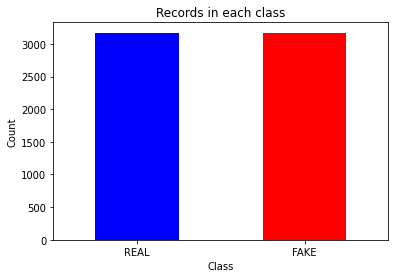

In [132]:
count_classes = df['target'].value_counts()
plt.title("Records in each class")
count_classes.plot(kind='bar', color=['b', 'r'])
plt.xticks(rotation='horizontal')
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

In [133]:
df["target"] = pd.factorize(df["target"])[0]

In [134]:
#get the number of classes
n_classes = df["target"].nunique()
n_classes

2

In [135]:
# random shuffle
df = df.sample(frac=1,random_state=49) 
df.head(5)

,Unnamed: 0,title,text,target
1720,7878,Hilarious Cartoon Reveals 2016 Political Versi...,Pinterest \nC.E. Dyer writes that the disaster...,0
4631,5771,Tom Hayden: Things Come Around in the Mideast,"By Padishah , July 23, 2006 at 12:19 am Link t...",0
4246,9346,The Pitfalls of Partial Disclosure – Examining...,"By Shem El-Jamal\nFor almost a decade, many of...",0
5115,26,House passes alternate abortion measure,Washington (CNN) The GOP-controlled House of R...,1
1086,10534,Fashwave Friday: Endgame,"6827 N. High Street, Suite 121 Worthington, Oh...",0


In [136]:
# check again
random_index=random.randint(0, len(df)-4)

for row in df[['text','target']][random_index:random_index+4].itertuples():
    print("• " + str(row))

• Pandas(Index=3170, text='WASHINGTON -- Rep. Louie Gohmert (R-Texas) launched a long-shot campaign Sunday for speaker of the House of Representatives, in the latest episode of the conservative rebellion against current Speaker John Boehner (R-Ohio).\n\nHouse members are set to vote for their next speaker on Tuesday, with Boehner heavily favored to win. Rep. Ted Yoho (R-Fla.) said Saturday that he is willing to serve as an alternative to Boehner. In addition, Reps. Jim Bridenstine (R-Okla.) and Thomas Massie (R-Ky.) have stated that they will oppose Boehner\'s re-election.\n\nGohmert\'s latest objection to Boehner -- although certainly not his only one -- was the speaker\'s decision to pass the so-called "cromnibus" spending bill in December without including a measure to block President Barack Obama\'s executive actions on immigration.\n\n"It was a terrible strategy and it follows a number of years of broken promises," Gohmert said on "Fox & Friends" while announcing his candidacy. "I

# 2. Створення тренувального та тестувального наборів даних.



In [137]:
train_sentences, test_sentences, \
train_labels, test_labels = train_test_split(df['text'].to_numpy(),
                                             df['target'].to_numpy(),
                                             test_size=0.2, 
                                             random_state=49)

In [138]:
train_sentences[:3]

array(["An FBI dive team reportedly pulled an object from a San Bernardino lake Friday, seeking evidence pinpointing the motive and history of the attackers who killed more than a dozen people during a holiday party.\n\nOne diver handed the unknown item to an official wearing gloves, who put the object in a plastic bag, the Press-Enterprise reports.\n\nInvestigators are looking for a hard drive that may have been dumped in the lake, a law enforcement official briefed on the investigation told The Associated Press. David Bowdich, chief of the FBI's Los Angeles office, said investigative leads indicated the shooters had been in the area the day of the massacre and said the search of the lake could take days.\n\nFox News has learned that in 2012, one of the gunmen, Syed Farook, conspired with former neighbor Enrique Marquez, the man who purchased the rifles used in the deadly attack in San Bernardino on Dec. 2. The plot would have targeted the Los Angeles area.\n\nIt appeared the two were

In [139]:
train_labels[:3]

array([1, 1, 1])

In [140]:
train_sentences.dtype # check data type

dtype('O')

In [141]:
train_labels.dtype # check data type

dtype('int64')

In [142]:
train_sentences.shape # check shape

(5068,)

In [143]:
test_sentences.shape # check shape

(1267,)

In [144]:
#TextVectorization transforms a batch of strings into either a list of token indices or a dense representation
text_vectorizer = TextVectorization(max_tokens=10000, 
                                    standardize="lower_and_strip_punctuation", 
                                    output_sequence_length=15)

In [145]:
#adapt dataset
text_vectorizer.adapt(train_sentences)

In [146]:
# example
sample_sentense = "Computer vision and deep learning"
text_vectorizer([sample_sentense])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[1881, 1898,    5, 1114, 3175,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0]])>

In [147]:
#the get_vocabulary() function provides the vocabulary to build a metadata file with one token per line
words = text_vectorizer.get_vocabulary()
#The vocabulary contains the padding token ('') and OOV token ('[UNK]') as well as the passed tokens
words[:10] # check data

['', '[UNK]', 'the', 'to', 'of', 'and', 'a', 'in', 'that', 'is']

In [148]:
#turns positive integers (indexes) into dense vectors of fixed size
embedding = Embedding(input_dim=10000, output_dim=128, input_length=15, name = 'embeding_1')
embedding

In [149]:
#example
sample_embed = embedding(text_vectorizer(["Computer vision and deep learning"]))
sample_embed

<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[ 0.02219423, -0.01566228,  0.00764818, ...,  0.01674639,
          0.0077601 ,  0.04880687],
        [-0.01020607, -0.02018758,  0.04567447, ..., -0.02020196,
          0.02318648, -0.00456125],
        [-0.04840731,  0.0198687 , -0.04803182, ..., -0.04367474,
         -0.03023669, -0.01660508],
        ...,
        [ 0.02113951,  0.0150087 , -0.00407283, ...,  0.03145221,
          0.04714879, -0.02439568],
        [ 0.02113951,  0.0150087 , -0.00407283, ...,  0.03145221,
          0.04714879, -0.02439568],
        [ 0.02113951,  0.0150087 , -0.00407283, ...,  0.03145221,
          0.04714879, -0.02439568]]], dtype=float32)>

# 3. Попередню оцінку точності моделі за допомогою методу Naive Bayes

In [150]:
#first model, using MultinomialNB()
model_0 = Pipeline([("tfidf", TfidfVectorizer()),
                    ("clf", MultinomialNB())])


In [151]:
# train model
model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [152]:
# get the score of the model
baseline_score = model_0.score(test_sentences, test_labels)
baseline_score

0.7932123125493291

In [153]:
# get the predictions
y_hat_0 = model_0.predict(test_sentences)

In [154]:
# check results
test_labels[:10]

array([0, 1, 0, 1, 1, 1, 1, 0, 0, 1])

In [155]:
# check results
y_hat_0[:10]

array([0, 1, 0, 1, 1, 1, 1, 0, 0, 0])

In [156]:
def calculate_results(y_true, y_pred):
    """
    Calculates model accuracy, precision, recall and f1 score of a classification model.

    Args:
    -----
    y_true = true labels in the form of a 1D array
    y_pred = predicted labels in the form of a 1D array

    Returns a dictionary of accuracy, precision, recall, f1-score.
    """

    # Calculate model accuracy
    model_accuracy = accuracy_score(y_true, y_pred) * 100
    # Calculate model precision, recall and f1 score using "weighted" average
    model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
    model_results = {"accuracy": model_accuracy,
                     "precision": model_precision,
                     "recall": model_recall,
                     "f1": model_f1}
    return model_results

In [157]:
# calculate results
res_0 = calculate_results(test_labels, y_hat_0)

In [158]:
test_sentences.dtype # check type of sentences

dtype('O')

# 4. Вирішення задачі класифікації за допомогою методу [GRU]

In [159]:
# GRU
# setting inputs and outputs of NN
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GRU(64)(x)
outputs = layers.Dense(1, activation="sigmoid")(x) # binary

In [160]:
#create model
model_1 = tf.keras.Model(inputs, outputs, name="model_gru")

In [161]:
# create model
model_1.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=["accuracy"]) 

In [162]:
# check model
model_1.summary()

Model: "model_gru"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_3 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embeding_1 (Embedding)      (None, 15, 128)           1280000   
                                                                 
 gru_2 (GRU)                 (None, 64)                37248     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,317,313
Trainable params: 1,317,313
Non-trainable params: 0
_______________________________________________

In [163]:
# train model
model_1_history = model_1.fit(train_sentences, 
                              train_labels, 
                              epochs=10, 
                              validation_data=(test_sentences, test_labels),
                              verbose=True)

Epoch 1/10
159/159 [==============================] - 6s 21ms/step - loss: 0.4164 - accuracy: 0.7968 - val_loss: 0.2762 - val_accuracy: 0.8761
Epoch 2/10
159/159 [==============================] - 3s 18ms/step - loss: 0.1377 - accuracy: 0.9489 - val_loss: 0.3130 - val_accuracy: 0.8737
Epoch 3/10
159/159 [==============================] - 3s 18ms/step - loss: 0.0494 - accuracy: 0.9838 - val_loss: 0.4236 - val_accuracy: 0.8635
Epoch 4/10
159/159 [==============================] - 3s 18ms/step - loss: 0.0244 - accuracy: 0.9915 - val_loss: 0.5647 - val_accuracy: 0.8650
Epoch 5/10
159/159 [==============================] - 3s 18ms/step - loss: 0.0086 - accuracy: 0.9972 - val_loss: 0.7258 - val_accuracy: 0.8532
Epoch 6/10
159/159 [==============================] - 3s 18ms/step - loss: 0.0038 - accuracy: 0.9994 - val_loss: 0.7896 - val_accuracy: 0.8658
Epoch 7/10
159/159 [==============================] - 3s 18ms/step - loss: 0.0034 - accuracy: 0.9996 - val_loss: 0.6966 - val_accuracy: 0.8642

In [164]:
# check on test data
print("...evaluating model...")
model_1.evaluate(test_sentences, test_labels)

...evaluating model...
40/40 [==============================] - 0s 11ms/step - loss: 0.8655 - accuracy: 0.8603


[0.8654985427856445, 0.8602999448776245]

In [165]:
# check shape
print("test_labels.shape = ", test_labels.shape)
print()

test_labels.shape =  (1267,)



In [166]:
# get the probabilities
y_prob = model_1.predict(test_sentences)

In [167]:
# get the classes
y_hat = y_prob.argmax(axis=-1)

In [168]:
# see the test labels
print("test_labels =\n", test_labels)
print()

test_labels =
 [0 1 0 ... 1 1 1]



In [177]:
# check results
res_1 = calculate_results(test_labels, y_hat)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# 5. Графічне відображення тренування моделі.




In [173]:
def plot_NN_history(model_history, suptitle):
    # plot data
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,6))
    fig.suptitle(suptitle, fontsize=18)
    
    axes[0].plot(model_history.history['accuracy'], label='train accuracy', color='m', axes=axes[0])
    axes[0].plot(model_history.history['val_accuracy'], label='val accuracy', color='c', axes=axes[0])
    axes[0].set_title("Model Accuracy", fontsize=16) 
    axes[0].legend(loc='upper left')

    axes[1].plot(model_history.history['loss'], label='train loss', color='m', axes=axes[1])
    axes[1].plot(model_history.history['val_loss'], label='val loss', color='c', axes=axes[1])
    axes[1].set_title("Model Loss", fontsize=16) 
    axes[1].legend(loc='upper left')

    plt.show()

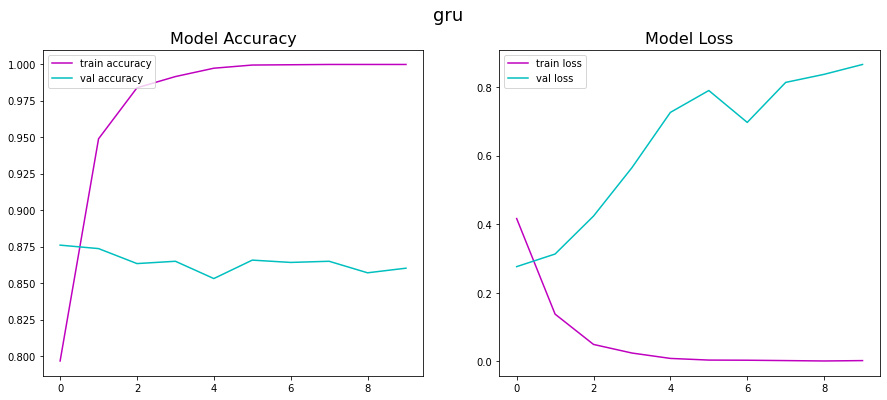

In [174]:
plot_NN_history(model_1_history, "gru")

#6. Порівняння результатів, отриманих у п.п. 3,4

In [175]:
def plot_results(results, ax1, ax2, ax3, ax4):
    
    
    ax1 = results['accuracy'].plot.bar(ax=ax1, color='m', legend=False)
    ax1.set_title("Accuracy", fontsize=16)
    
    ax2 = results['precision'].plot.bar(ax=ax2, color='c', legend=False)
    ax2.set_title("Precision", fontsize=16)   
    
    ax3 = results['recall'].plot.bar(ax=ax3, color='g', legend=False)
    ax3.set_title("Recall", fontsize=16) 
    
    ax4 = results['f1'].plot.bar(ax=ax4, color='r', legend=False)
    ax4.set_title("F1", fontsize=16) 
    
    print()

In [178]:
results = [res_0, res_1]
results = pd.concat(results, ignore_index=True)
results.index = results['model']
results = results.drop(columns=['model'])
results # check data

TypeError: ignored

In [ ]:
# plot data
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=4, figsize=(20,8))
plt.suptitle("Performance of the naive bayes & VARIANT", fontsize=18) 
plot_results(results, ax1, ax2, ax3, ax4)
plt.show()

# 7. Висновок